In [ ]:
from google.colab import drive
import sys, os
import warnings 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install scikit-optimize


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 4.0 MB/s eta 0:00:00


In [ ]:
# this block used to import modules
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
import lightgbm as lgb
from scipy.stats import randint, uniform

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image, display

In [ ]:
# the data in the diamonds.csv file
diamonds_df = pd.read_csv('/content/drive/Shareddrives/ECE219_P4/diamonds.csv')
diamonds_df = diamonds_df.drop(["Unnamed: 0"], axis = 1)

In [ ]:
diamonds_df.head(-20)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,330,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,327,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,328,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,337,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,338,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53915,0.77,Ideal,E,SI2,62.1,56.0,2753,5.84,5.86,3.63
53916,0.74,Good,D,SI1,63.1,59.0,2756,5.71,5.74,3.61
53917,0.90,Very Good,J,SI1,63.2,60.0,2754,6.12,6.09,3.86
53918,0.76,Premium,I,VS1,59.3,62.0,2753,5.93,5.85,3.49


## Handling Categorial Features

In [ ]:
cut_labels_map = {'Fair' : 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
color_labels_map = {'D': 6, 'E': 5, 'F': 4 , 'G': 3 , 'H': 2, 'I': 1, 'J': 0}
clarity_labels_map = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diamonds_df = diamonds_df.replace({'cut': cut_labels_map, 'color': color_labels_map, 'clarity': clarity_labels_map})

In [ ]:
diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,4,5,1,61.5,55.0,330,3.95,3.98,2.43
1,0.21,3,5,2,59.8,61.0,327,3.89,3.84,2.31
2,0.23,1,5,4,56.9,65.0,328,4.05,4.07,2.31
3,0.29,3,1,3,62.4,58.0,337,4.20,4.23,2.63
4,0.31,1,0,1,63.3,58.0,338,4.34,4.35,2.75


## Data Inspection

## Question 1.1

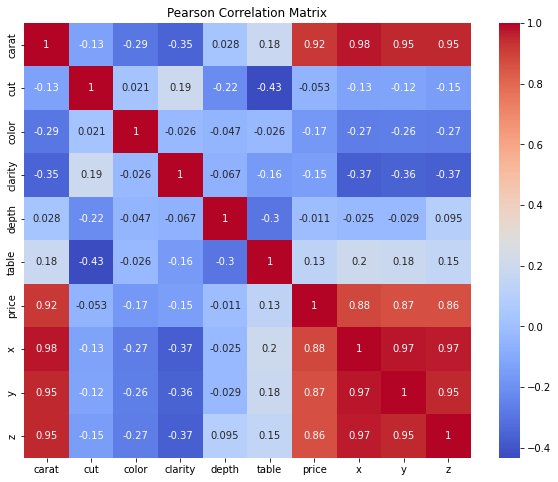

In [ ]:
corr_matrix = diamonds_df.corr()

# Plot the heatmap
fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, cmap='coolwarm')
plt.title('Pearson Correlation Matrix')
plt.show()


### Carat has the highest absolute correlation with the target variable (price), and its correlation with price is 0.92. 
### And from the heatmap, we can find that the features 'carat', 'x', 'y' and 'z' have high positive correlations with the target variable 'price'. However, the other features ('table', 'depth', 'clarity', 'color', 'cut') have low absolute correlations with the target variable (among them, only 'table' has positive correlation with 'price'). This does not make sense, based on our knowledge, e.g., the correlative between the 'color' and 'price' should be positive (the better the color of the diamond, the higher the price), but the heatmap shows a negative correlation. This pattern suggests the dataset might be biased, diamond with low 'clarity', 'color' or 'cut' tends to have relatively larger 'carat' (or 'x', 'y', 'z'), while the features 'carat' (or 'x', 'y', 'z') have more impacts on the price than the 'clarity', 'color' or 'cut, so this kind of diamond still tend to have high price. And diamond with high 'clarity', 'color', or 'cut' tends to have smaller 'carat' (or 'x', 'y', 'z'), so the diamond would not have very high price. This explains the pattern here, which also fits the real life, i.e. the diamond with higher quality tends to be less and smaller. And this also suggests, we should not only take 'clarity', 'color', 'cut' as the predicting features, (in the dataset, the 'price' does not reflect the real impacts), but must take any or any combinations among 'carat', 'x', 'y', and 'z'.

## Question 1.2

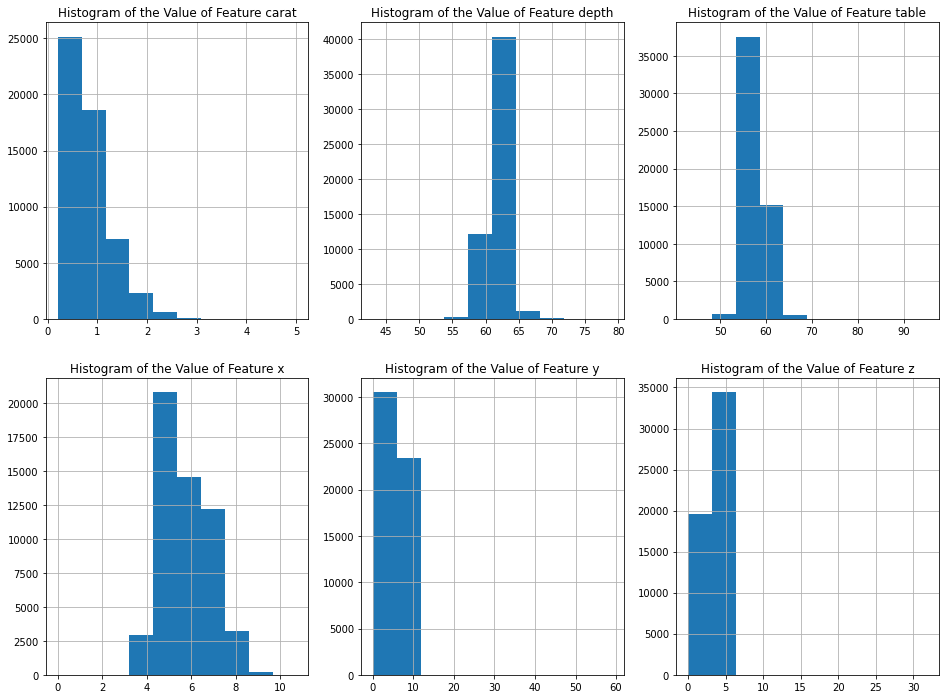

In [ ]:
fig, axes = plt.subplots(2, 3, figsize = (16, 12))
diamonds_df['carat'].hist(ax=axes[0,0])
axes[0,0].set_title('Histogram of the Value of Feature carat')
diamonds_df['depth'].hist(ax=axes[0,1])
axes[0,1].set_title('Histogram of the Value of Feature depth')
diamonds_df['table'].hist(ax=axes[0,2])
axes[0,2].set_title('Histogram of the Value of Feature table')
diamonds_df['x'].hist(ax=axes[1,0])
axes[1,0].set_title('Histogram of the Value of Feature x')
diamonds_df['y'].hist(ax=axes[1,1])
axes[1,1].set_title('Histogram of the Value of Feature y')
diamonds_df['z'].hist(ax=axes[1,2])
axes[1,2].set_title('Histogram of the Value of Feature z')
plt.show()

What preprocessing can be done if the distribution of a feature has high skewness?
1. We can remove outliers to reduce the skewness of the distribution of a feature. However, we might remove important information from the data when using this method. 
2. We can use log transformation to reduce the impact of outliers and to normalize the distribution of a feature. (There are also some other transformation methods available to reduce the skewness of the distribution of a feature).
3. We can also group the values of the feature into bins (a specified range) based on their values.

## Question 1.3

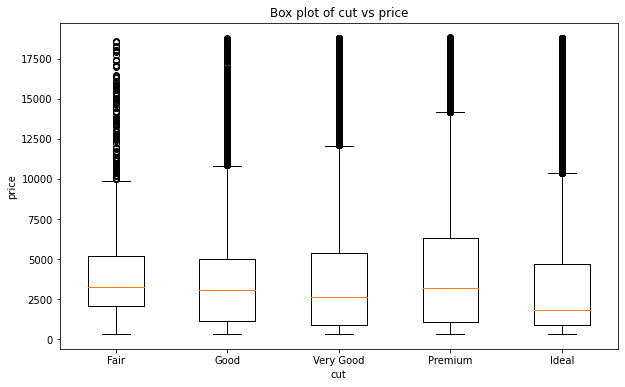

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([diamonds_df[diamonds_df['cut'] == 0]['price'], 
            diamonds_df[diamonds_df['cut'] == 1]['price'], 
            diamonds_df[diamonds_df['cut'] == 2]['price'], 
            diamonds_df[diamonds_df['cut'] == 3]['price'], 
            diamonds_df[diamonds_df['cut'] == 4]['price']], 
            labels = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
            )
plt.title('Box plot of cut vs price')
plt.xlabel('cut')
plt.ylabel('price')
plt.show()

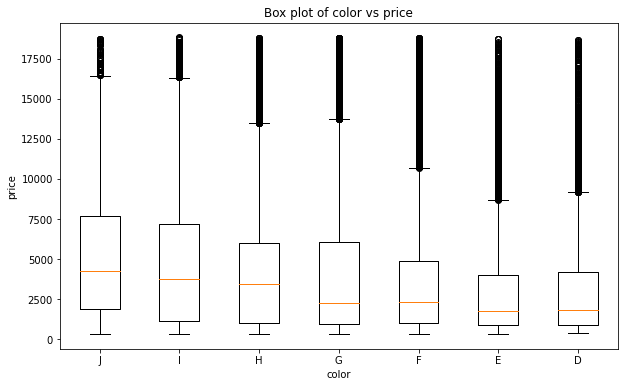

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([diamonds_df[diamonds_df['color'] == 0]['price'], 
             diamonds_df[diamonds_df['color'] == 1]['price'], 
             diamonds_df[diamonds_df['color'] == 2]['price'], 
             diamonds_df[diamonds_df['color'] == 3]['price'], 
             diamonds_df[diamonds_df['color'] == 4]['price'], 
             diamonds_df[diamonds_df['color'] == 5]['price'], 
             diamonds_df[diamonds_df['color'] == 6]['price']], 
            labels = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
            )
plt.title('Box plot of color vs price')
plt.xlabel('color')
plt.ylabel('price')
plt.show()

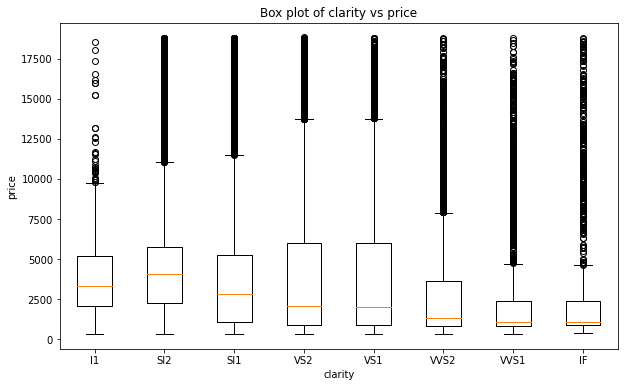

In [ ]:
plt.figure(figsize=(10, 6))
plt.boxplot([diamonds_df[diamonds_df['clarity'] == 0]['price'], 
             diamonds_df[diamonds_df['clarity'] == 1]['price'], 
             diamonds_df[diamonds_df['clarity'] == 2]['price'], 
             diamonds_df[diamonds_df['clarity'] == 3]['price'], 
             diamonds_df[diamonds_df['clarity'] == 4]['price'], 
             diamonds_df[diamonds_df['clarity'] == 5]['price'], 
             diamonds_df[diamonds_df['clarity'] == 6]['price'], 
             diamonds_df[diamonds_df['clarity'] == 7]['price']], 
            labels = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
            )
plt.title('Box plot of clarity vs price')
plt.xlabel('clarity')
plt.ylabel('price')
plt.show()

### From the boxplot, we can see that, in most cases, lower quality will lead to a higher mean price. For example, in the color vs price box plot, we can see that trend(D means the best quality yet it has the lowest mean price). We also find a lot of outliers in all box plots. That indicates that the data is skewed and not normally distributed.Since the data is not normally distributed, the mean value of data will not be a good representation of the data. That explains why the better quality leads to a lower mean price. Therefore, more data preprocessing techniques like standardization could be used. And this may also explain that the dataset is biased.

## Question 1.4

In [ ]:
color_counts = diamonds_df['color'].value_counts()
cut_counts = diamonds_df['cut'].value_counts()
clarity_counts = diamonds_df['clarity'].value_counts()

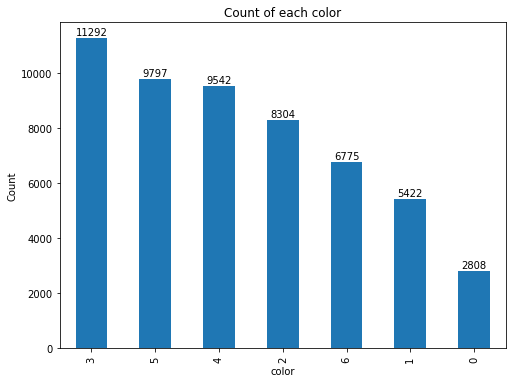

In [ ]:
plt.figure(figsize=(8, 6))
ax = color_counts.plot(kind='bar')
ax.set_title('Count of each color')
ax.set_xlabel('color')
ax.set_ylabel('Count')

# add count labels on top of each bar
for i, v in enumerate(color_counts):
    ax.text(i, v+100, str(v), ha='center')

# show the plot
plt.show()

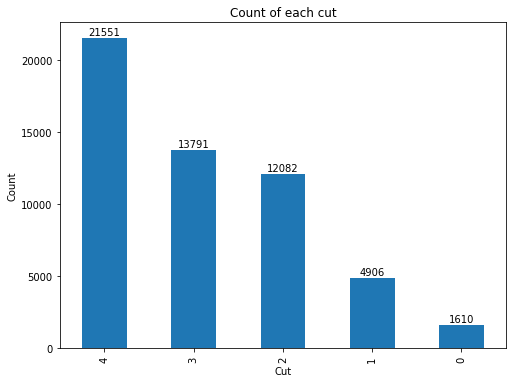

In [ ]:
plt.figure(figsize=(8, 6))
ax1 = cut_counts.plot(kind='bar')
ax1.set_title('Count of each cut')
ax1.set_xlabel('Cut')
ax1.set_ylabel('Count')

# add count labels on top of each bar
for i, v in enumerate(cut_counts):
    ax1.text(i, v+200, str(v), ha='center')

# show the plot
plt.show()

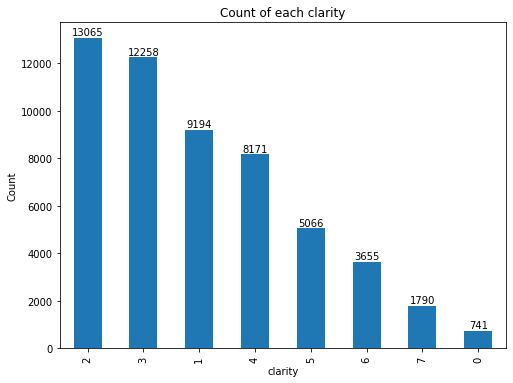

In [ ]:
plt.figure(figsize=(8, 6))
ax = clarity_counts.plot(kind='bar')
ax.set_title('Count of each clarity')
ax.set_xlabel('clarity')
ax.set_ylabel('Count')

# add count labels on top of each bar
for i, v in enumerate(clarity_counts):
    ax.text(i, v+100, str(v), ha='center')

# show the plot
plt.show()

## Question 2.1

In [ ]:
scalar = StandardScaler()
scalar.fit(diamonds_df)
scaled_diamonds = scalar.transform(diamonds_df)
scaled_diamonds_df = pd.DataFrame(scaled_diamonds, columns=diamonds_df.columns)
scaled_diamonds_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,-1.198168,0.981473,0.937163,-1.245215,-0.174092,-1.099672,-0.903594,-1.587837,-1.536196,-1.571129
1,-1.240361,0.085889,0.937163,-0.638095,-1.360738,1.585529,-0.904346,-1.641325,-1.658774,-1.741175
2,-1.198168,-1.705279,0.937163,0.576145,-3.385019,3.375663,-0.904095,-1.498691,-1.457395,-1.741175
3,-1.071587,0.085889,-1.414272,-0.030975,0.454133,0.242928,-0.901839,-1.364971,-1.317305,-1.287720
4,-1.029394,-1.705279,-2.002131,-1.245215,1.082358,0.242928,-0.901588,-1.240167,-1.212238,-1.117674


## Question 2.2

In [ ]:
X = scaled_diamonds_df.drop('price', axis = 1)
y = scaled_diamonds_df[['price']].values.flatten()
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Compute mutual information scores between each feature and the target variable
mi_scores = mutual_info_regression(X_train, y_train)

# Select the top 5 features based on their mutual information scores
k_best = SelectKBest(mutual_info_regression, k=5)
X_train_new = k_best.fit_transform(X_train, y_train)
X_test_new = k_best.transform(X_test)

# Train and evaluate a linear regression model on the selected features
model = LinearRegression()
model.fit(X_train_new, y_train)
y_pred = model.predict(X_test_new)

# Calculate the RMSE of the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Selected features: ", np.array(X.columns.values)[k_best.get_support()])
print("R-squared score: ", rmse)

Selected features:  ['carat' 'clarity' 'x' 'y' 'z']
R-squared score:  0.3313664257914315


## Or the method below, not sure!

In [ ]:
#seperate the target and the features
price_arr = scaled_diamonds_df[['price']].values.flatten()
scaled_diamonds_wo_pirce_df = (scaled_diamonds_df.drop('price', axis = 1))


In [ ]:
price_arr.shape

(53940,)

In [ ]:
scaled_diamonds_wo_pirce_df.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-1.198168,0.981473,0.937163,-1.245215,-0.174092,-1.099672,-1.587837,-1.536196,-1.571129
1,-1.240361,0.085889,0.937163,-0.638095,-1.360738,1.585529,-1.641325,-1.658774,-1.741175
2,-1.198168,-1.705279,0.937163,0.576145,-3.385019,3.375663,-1.498691,-1.457395,-1.741175
3,-1.071587,0.085889,-1.414272,-0.030975,0.454133,0.242928,-1.364971,-1.317305,-1.287720
4,-1.029394,-1.705279,-2.002131,-1.245215,1.082358,0.242928,-1.240167,-1.212238,-1.117674


In [ ]:
mi_scores = mutual_info_regression(scaled_diamonds_wo_pirce_df.values, price_arr)

In [ ]:
# print the two features that have the two lowest mutual information scores
for i, feature in enumerate(scaled_diamonds_wo_pirce_df.columns):
    print(f"{feature}: {mi_scores[i]:.3f}")

carat: 1.656
cut: 0.056
color: 0.140
clarity: 0.217
depth: 0.031
table: 0.036
x: 1.412
y: 1.422
z: 1.361


In [ ]:
prepared_diamonds_arr = scaled_diamonds_wo_pirce_df.drop(["depth", "table"], axis = 1).values

By using feature selection methods such as 'mutual information regression' and computing F scores allows us to find the most relative and useful features and drop unrelated features. By doing so, we can improve the performence of our model by reducing overfitting. 

For some models such as linear regression model, we can see a signigicant improvement in terms of RMSE(lower RMSE). However, for those non linear models such as neural network models(activation layers introduces non-linearity), there may not a significant drop in RMSE because those models can automatically select relevent features.

We find that feature 'depth' and 'table' have the lowest MI w.r.t to the target(price).

In [ ]:
prepared_diamonds_arr.shape

(53940, 7)

## Question 3


In [ ]:
def linear_regression(model):
  # linear regression without regularization
  kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
  train_rmse = []
  val_rmse = []
  for train_index, val_index in kf_10.split(prepared_diamonds_arr):
    X_train, X_val = prepared_diamonds_arr[train_index], prepared_diamonds_arr[val_index]
    y_train, y_val = price_arr[train_index], price_arr[val_index]

    # # Convert X_train and X_val to numpy arrays
    # X_train = X_train.values
    # X_val = X_val.values

    # Train the linea regression model on the training set
    model.fit(X_train, y_train)

    # Make predictions on the training and validation sets
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Compute the RMSE for the training and validation sets
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

  # Compute the average RMSE for the training and validation sets
  avg_train_rmse = np.mean(train_rmse)
  avg_val_rmse = np.mean(val_rmse)
  return avg_train_rmse, avg_val_rmse

In [ ]:
# linear regression without regularization
avg_train_rmse_0, avg_val_rmse_0 = linear_regression(LinearRegression())
print("avg_train_rmse: {:.12f}".format(avg_train_rmse_0))
print("avg_val_rmse: {:.8f}".format(avg_val_rmse_0))

avg_train_rmse: 0.305721173659
avg_val_rmse: 0.30643155


In [ ]:
# lasso regression
avg_train_rmse_1, avg_val_rmse_1 = linear_regression(Lasso(alpha=0.1))
print("avg_train_rmse: {:.8f}".format(avg_train_rmse_1))
print("avg_val_rmse: {:.8f}".format(avg_val_rmse_1))

avg_train_rmse: 0.38109265
avg_val_rmse: 0.38103165


In [ ]:
# Ridge regression
avg_train_rmse_2, avg_val_rmse_2 = linear_regression(Ridge(alpha=10))
print("avg_train_rmse: {:.12f}".format(avg_train_rmse_2))
print("avg_val_rmse: {:.8f}".format(avg_val_rmse_2))

avg_train_rmse: 0.305724245559
avg_val_rmse: 0.30638856


## Question 4.1

(a) ordinary least squares (linear regression without regularization): It has no regularization effect.

(b) Lasso: applies a L1 regularization. It is a penalty term proportional to the absolute value of the coefficients added to the objective function.The first order derivative of the penalty term w1, w2, ... will be 1 is the parameter is non zero and 0 if the parameter is 0. As a result, Lasso encourages sparsity in the learned parameter set. That means some parameters will be set to zero.

(c) Ridge regression: a L2 regularization. It is a penalty term proportional to the squared coefficients added to the objective function. The derivative of those squared parameters will be themselves. Because the penalty term is differentiable, there may be a solution that minimizes the objective function without setting any coefficients exactly to zero. Therefore, ridge regression encourages smaller values of the coefficients but does not explicitly encourage any coefficients to be exactly zero.


## Question 4.2

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(prepared_diamonds_arr, price_arr, test_size=0.2, random_state=42)
# Define a range of alpha values to test
alphas = np.logspace(-4, 4, 40)

In [ ]:
# Create a Ridge regression object
lr = LinearRegression()

# Use GridSearchCV to find the optimal value of alpha
grid = GridSearchCV(estimator=lr, param_grid={}, cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = grid.predict(X_valid)

# Calculate the RMSE on the validation set
rmse_val_0 = np.sqrt(mean_squared_error(y_valid, y_pred))


# Print the best value of alpha and the corresponding mean squared error
print("Best RMSE:", (-grid.best_score_)**(0.5))
# Print the RMSE on the validation set
print("Validation RMSE: {:.8f}".format(rmse_val_0))

Best RMSE: 0.30604467185524215
Validation RMSE: 0.30761774


In [ ]:
# Create a Ridge regression object
la = Lasso()

# Use GridSearchCV to find the optimal value of alpha
grid = GridSearchCV(estimator=la, param_grid=dict(alpha=alphas), cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = grid.predict(X_valid)

# Calculate the RMSE on the validation set
rmse_val_1 = np.sqrt(mean_squared_error(y_valid, y_pred))

# Print the best value of alpha and the corresponding mean squared error
print("Best alpha:", grid.best_params_['alpha'])
print("Best RMSE:", (-grid.best_score_)**(0.5))
# Print the RMSE on the validation set
print("Validation RMSE: {:.8f}".format(rmse_val_1))

Best alpha: 0.0006614740641230146
Best RMSE: 0.3057930932191351
Validation RMSE: 0.30770741


In [ ]:
# Create a Ridge regression object
ridge = Ridge()

# Use GridSearchCV to find the optimal value of alpha
grid = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas), cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = grid.predict(X_valid)

# Calculate the RMSE on the validation set
rmse_val_2 = np.sqrt(mean_squared_error(y_valid, y_pred))

# Print the best value of alpha and the corresponding mean squared error
print("Best alpha:", grid.best_params_['alpha'])
print("Best RMSE:", (-grid.best_score_)**(0.5))
# Print the RMSE on the validation set
print("Validation RMSE: {:.8f}".format(rmse_val_2))

Best alpha: 34.55107294592218
Best RMSE: 0.3059634521525212
Validation RMSE: 0.30760941


The best regularization scheme ridge regression, and the optimal penalty parameter is alpha = 34.551. We get this answer by selecting 40 numbers among 1e-4 to 1e4 as alpha and we choose the alpha that has the lowest RMSE.

## Question 4.3

In [ ]:
#seperate the target and the features
unscale_price_arr = diamonds_df[['price']].values.flatten()
unscale_diamond_arr = (diamonds_df.drop(['price',"depth", "table" ], axis = 1)).values

In [ ]:
X_train_us, X_valid_us, y_train_us, y_valid_us = train_test_split(unscale_diamond_arr, unscale_price_arr, test_size=0.2, random_state=42)
# Define a range of alpha values to test
alphas = np.logspace(-4, 4, 40)
# Create a Ridge regression object
ridge = Ridge()

# Use GridSearchCV to find the optimal value of alpha
grid = GridSearchCV(estimator=ridge, param_grid=dict(alpha=alphas), cv=10, scoring='neg_mean_squared_error')
grid.fit(X_train_us, y_train_us)

# Make predictions on the validation set
y_pred_us = grid.predict(X_valid_us)

# Calculate the RMSE on the validation set
rmse_val_2_us = np.sqrt(mean_squared_error(y_valid_us, y_pred_us))

# Print the best value of alpha and the corresponding mean squared error
print("Best alpha:", grid.best_params_['alpha'])
print("Best RMSE:", (-grid.best_score_)**(0.5))
# Print the RMSE on the validation set
print("Validation RMSE: {:.8f}".format(rmse_val_2_us))

Best alpha: 5.2233450742668435
Best RMSE: 1220.8294111899638
Validation RMSE: 1227.14856110


We used the unscaled data to train our ridge regression model and the RMSE we get is 1227.15. This is much larger than the RMSE we get from ridge regression model that uses scaled data. Therefore, we believe that feature standardization plays an important role in improving the model performance.

## Question 4.4

The p-value measures the statistical significance of the relationship between one of the features and the target variable(here, it is price). The p-value is used to test the null hypothesis that the coefficient of a feature is equal to zero(when the coefficient is 0, the feature has no effect on the final predicted result, so no relationship between that feature and the target). 

We can infer the most significant features by setting a significance level for the p-value. If the p value of that feature is less than that significance level, the null hypothesis is rejected and we believe there is a relationship between that feature and the target. 

##Polynomial Regression 

## Question 5.1

In [ ]:
def polynomial_regression(model, degree):
  # linear regression without regularization
  kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
  train_rmse = []
  val_rmse = []
  X_selected = scaled_diamonds_df[['carat', 'clarity', 'x', 'y', 'z']]
  y = scaled_diamonds_df[['price']].values
  # Create PolynomialFeatures object with degree 2
  poly = PolynomialFeatures(degree=degree, include_bias=False)

  # Generate new feature matrix with products of features
  X_poly = poly.fit_transform(X_selected)
  feature_names = poly.get_feature_names_out()

  for train_index, val_index in kf_10.split(X_selected):
    X_train, X_val = X_poly[train_index], X_poly[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Train the linear regression model on the training set
    model.fit(X_train, y_train)   
    # Make predictions on the training and validation sets

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Compute the RMSE for the training and validation sets
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    # Compute the average RMSE for the training and validation sets
  avg_train_rmse = np.mean(train_rmse)
  avg_val_rmse = np.mean(val_rmse)
  return avg_train_rmse, avg_val_rmse, model, feature_names

In [ ]:
# linear regression without regularization
for i in range(1, 7, 1):
  print("current degree is:", i)
  avg_train_rmse_0, avg_val_rmse_0, model, feature_names = polynomial_regression(LinearRegression(), i)
  print("avg_train_rmse: {:.12f}".format(avg_train_rmse_0))
  print("avg_val_rmse: {:.8f}".format(avg_val_rmse_0))
  if (i < 3):
    print("new features are:", feature_names)
    print("The intercept of the model is:", model.intercept_)
    print("The parameters of the model are:", model.coef_)
  print("-"*30)

current degree is: 1
avg_train_rmse: 0.335352057073
avg_val_rmse: 0.33665765
new features are: ['carat' 'clarity' 'x' 'y' 'z']
The intercept of the model is: [-0.00078228]
The parameters of the model are: [[ 1.16971668  0.19665774 -0.13420801  0.02668547 -0.07701107]]
------------------------------
current degree is: 2
avg_train_rmse: 0.275594024800
avg_val_rmse: 0.45453605
new features are: ['carat' 'clarity' 'x' 'y' 'z' 'carat^2' 'carat clarity' 'carat x'
 'carat y' 'carat z' 'clarity^2' 'clarity x' 'clarity y' 'clarity z' 'x^2'
 'x y' 'x z' 'y^2' 'y z' 'z^2']
The intercept of the model is: [-0.09974194]
The parameters of the model are: [[ 0.90827473  0.20919549 -0.35805077  0.55806774 -0.13218657 -0.18520621
   0.08826278  0.21698267  0.365616   -0.32853518 -0.00497741 -0.02955865
   0.10559808  0.01792456  0.28188639 -0.56985394 -0.36553535 -0.12153601
   0.89628806  0.00464589]]
------------------------------
current degree is: 3
avg_train_rmse: 0.261947452036
avg_val_rmse: 3.2930

When the degree is 1, we can find the feature 'carat' has the highest absolute coefficient value, which means with the degree of 1, 'carat' is the most salient feature. 

When the degree is 2, we can find the features 'carat', 'y', 'x y', and 'y z' have relatively high absolute coefficient values, which means with the degree of 2, 'carat', 'y', 'x y' and 'y z' are salient features.

In [ ]:
# lasso regression
for i in range(1, 7, 1):
  avg_train_rmse_1, avg_val_rmse_1, model, feature_names = polynomial_regression(Lasso(alpha=0.1, max_iter=1000), i)
  print("avg_train_rmse: {:.8f}".format(avg_train_rmse_1))
  print("avg_val_rmse: {:.8f}".format(avg_val_rmse_1))
  if (i < 3):
    print("new features are:", feature_names)
    print("The intercept of the model is:", model.intercept_)
    print("The parameters of the model are:", model.coef_)
  print("-"*30)

avg_train_rmse: 0.38109265
avg_val_rmse: 0.38103165
new features are: ['carat' 'clarity' 'x' 'y' 'z']
The intercept of the model is: [-0.00071377]
The parameters of the model are: [0.83748347 0.04835034 0.         0.         0.        ]
------------------------------
avg_train_rmse: 0.37826211
avg_val_rmse: 0.37976554
new features are: ['carat' 'clarity' 'x' 'y' 'z' 'carat^2' 'carat clarity' 'carat x'
 'carat y' 'carat z' 'clarity^2' 'clarity x' 'clarity y' 'clarity z' 'x^2'
 'x y' 'x z' 'y^2' 'y z' 'z^2']
The intercept of the model is: [-0.04502409]
The parameters of the model are: [ 0.79968281  0.04010728  0.          0.          0.          0.
  0.          0.0335146   0.00116731  0.         -0.          0.
  0.          0.          0.00960465  0.00100026  0.          0.
  0.          0.        ]
------------------------------
avg_train_rmse: 0.37428226
avg_val_rmse: 1.18037188
------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.845e+03, tolerance: 4.847e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.980e+03, tolerance: 4.864e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.473e+03, tolerance: 4.886e+00

avg_train_rmse: 0.35497330
avg_val_rmse: 2.27938330
------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.503e+03, tolerance: 4.847e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.657e+03, tolerance: 4.864e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+02, tolerance: 4.886e+00

avg_train_rmse: 0.35566231
avg_val_rmse: 7.46482009
------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.653e+03, tolerance: 4.847e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.677e+03, tolerance: 4.864e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.405e+03, tolerance: 4.886e+00

avg_train_rmse: 0.35504569
avg_val_rmse: 17.86048476
------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.669e+03, tolerance: 4.833e+00
  model = cd_fast.enet_coordinate_descent(


In [ ]:
# Ridge regression
for i in range(1, 7, 1):
  avg_train_rmse_2, avg_val_rmse_2, model, feature_names = polynomial_regression(Ridge(alpha=1, max_iter=1000), i)
  print("avg_train_rmse: {:.8f}".format(avg_train_rmse_2))
  print("avg_val_rmse: {:.8f}".format(avg_val_rmse_2))
  if (i < 3):
    print("new features are:", feature_names)
    print("The intercept of the model is:", model.intercept_)
    print("The parameters of the model are:", model.coef_)
  print("-"*30)

avg_train_rmse: 0.33535208
avg_val_rmse: 0.33665151
new features are: ['carat' 'clarity' 'x' 'y' 'z']
The intercept of the model is: [-0.00078242]
The parameters of the model are: [[ 1.16917037  0.1966609  -0.13367185  0.02663504 -0.07696055]]
------------------------------
avg_train_rmse: 0.27559863
avg_val_rmse: 0.44476629
new features are: ['carat' 'clarity' 'x' 'y' 'z' 'carat^2' 'carat clarity' 'carat x'
 'carat y' 'carat z' 'clarity^2' 'clarity x' 'clarity y' 'clarity z' 'x^2'
 'x y' 'x z' 'y^2' 'y z' 'z^2']
The intercept of the model is: [-0.10083268]
The parameters of the model are: [[ 0.90136631  0.20924518 -0.35120365  0.55597621 -0.13075013 -0.18463857
   0.0884761   0.22824774  0.34923251 -0.32449929 -0.00500614 -0.02943563
   0.10542442  0.01783172  0.23908618 -0.52508455 -0.31946672 -0.11563785
   0.84365831  0.00462894]]
------------------------------
avg_train_rmse: 0.26224964
avg_val_rmse: 5.76968797
------------------------------
avg_train_rmse: 0.25514220
avg_val_rmse

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.42658e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.64477e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.54239e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.86254e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Il

avg_train_rmse: 0.25062402
avg_val_rmse: 9718.92123274
------------------------------


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.14054e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


avg_train_rmse: 0.24783831
avg_val_rmse: 164622.09044429
------------------------------


For the polynomial regression model without regularization, the best degree of polynomail is 1. 

For the polynomial regression model with Lasso, the best degree of polynomial is 2.

For the polynomial regression model with Ridge, the best degree of polynomail is 1. 

I found the optimal degree by comparing the average training and testing rmse of the models, the ones I picked almost have the lowest rmse either in training dataset or the testing dataset.

A very high-order polynomial imply the model would fits on the training data very well, but it might be too well for the generalized data (overfitting), so its performance on testing data would be not good and sometimes very bad. From the results above, we can find the average rmse for training data is slightly decreasing as the degree increases, but the average rmse for testing data is dramatically increasing as the degree increases (e.g. when the degree is 1 with linear regression w/o regularization, the avg rmse for training and testing data are both about 0.34, but when the degree is 6, the rmse for training data is 0.25, and the rmse for testing data is 280656967.62). 

## Question 6.1

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(prepared_diamonds_arr, price_arr, test_size=0.2, random_state=42)

In [ ]:
# Define your parameter grid for the grid search
param_grid = {'hidden_layer_sizes': [(50,),(100,), (50,50), (50,100)],
              'alpha': [0.001,0.05,0.01]}

# Instantiate your MLPRegressor
mlp = MLPRegressor(solver='adam', max_iter=1000)

# Define the GridSearchCV object
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to your data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters: ", grid_search.best_params_)



Best parameters:  {'alpha': 0.01, 'hidden_layer_sizes': (50, 100)}


In [ ]:
NN_best = grid_search.best_estimator_
y_train_pred = NN_best.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
print(f"Train RMSE: ", train_rmse)

Train RMSE:  0.1315797535543844


In [ ]:
# Evaluate the performance of the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
print("Test RMSE: ", mse**0.5)

Test RMSE:  0.13443418437557417


## Question 6.2

The performance of Neural network model is much better than the performance of linear regression in terms of RMSE. The Neural network model has an RMSE of 0.14 while the linear regression has an RMSE of 0.305. This is because neural network model introduces non-linearity by adding activation layer while linear regression assumes the relation between features and target is always linear. In real world problem, the relationship between the feature and the target is not linear, which means that a neural network may be better able to capture patterns in the data. 

Also, neural network model can automatically find and select the most important features while we can only manually select the features when using linear regression model. The input features for linear regression need to be transformed and selected manually before being used in the model. Neural networks, on the other hand, can learn the relevant features automatically from the raw data.

## Question 6.3

The MLPRegressor class in scikit-learn uses ReLU activation layer by default. It is a very popular activation layer used in deep learning and it has mant advantages. It is computationally efficient to compute because it's a simple max(0,x) function. It can help to avoid the vanishing gradient problem because it does not saturate for positive input values.

## Question 6.4

1. Increasing the depth of the network will lead to higher complexity and that can lead to overfitting problem. That will lead to a poorer performance on the validation set.

2. Increased depth will lead to more parameters. That also means more calculation are needed to compute all the parameters in the network. Therefore, the iteration need to converge will increase and the time taken to train the model will increase.

3. Increasing depth of network may also lead to vanishing gradients problem. Since all the parameters are computed at the back propogation, the gradient close to the end will be calculated at the first and the gradient will be smaller and smaller as the gradient back propagated and finally becomes 0 if the depth is large enough. If the gradient of a layer is zero, the gradient of the layers before that layer will also be 0 due to the mechanics of back propogation(dz/da * dl/dz = 0 if dl/dz = 0). Vanishing gradients problem will make the network learn ineffectively because no gradient can be learned(no more learning) when the gradient is 0.

## Random Forest

### Q 7.1

* Maximum number of features: increase the value of the hyperparameter max_features (maximum number of features) can lead to a more complex model with more variance, but this can also lead to overfitting.\
Setting a suitable number of features can avoid the model from relying on too much on individual features that are not representative for the whole dataset, and thus can lead to regularization and prevent model from overfitting the training data.

* Number of trees: increase the value of the hyperparameter n_estimators (number of trees) usually leads to better performance, but may cause the training time increases a lot.\
And increasing the number of trees can lead to regularization by reducing overfiiting (more trees means that the model's predictions will be averaged over many different trees, and thus reduce the impact of individual trees that might be overfitting the data).


* Depth of each tree: increase the value of the hyperparameter max_depth (depth of each tree) can also lead to a more complex model with more variance, and cause overfitting.\
Setting a limitation to the depth of each tree can lead to regularization by preventing the model from being too complex and overfitting the training data.


### Q 7.2

In random forest, each decision tree splits the data into smaller regions based on the thresholds applied to each features. Though an individual decision tree might not be able to form complex decision boundaries, the ensemble of trees (each trained on different subsets of data and features) is able to create a highly non-linear decision boundary with its mechanisms - random feature selection and bootstrap aggregation.\
With random feature selection, each decision tree in the ensemble uses a different subset of features to make decision (lead to different splits and different decision boundaries).\
With bootstrap aggregation, each decison tree in the ensemble is trained on different subset of the training data (lead them to different decision boundaries).\
In these ways, the ensemble can find complex interactions between features and thus leads to highly non-linear decision boundaries.

### Q 7.3

In [ ]:
def random_forest():
  # linear regression without regularization
  kf_10 = KFold(n_splits=10, shuffle=True, random_state=42)
  train_rmse = []
  val_rmse = []
  oobs = []
  X_selected = scaled_diamonds_df[['carat', 'clarity', 'x', 'y', 'z']].values
  y = scaled_diamonds_df[['price']].values

  # Create PolynomialFeatures object with degree 2
  model = RandomForestRegressor(max_features = 10, n_estimators = 100, max_depth = 4, oob_score=True)

  for train_index, val_index in kf_10.split(X_selected):
    X_train, X_val = X_selected[train_index], X_selected[val_index]
    y_train, y_val = y[train_index].flatten(), y[val_index].flatten()

    # Train the linear regression model on the training set
    model.fit(X_train, y_train)   
    # Make predictions on the training and validation sets

    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Compute the RMSE for the training and validation sets
    train_rmse.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    val_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    oobs.append(model.oob_score_)

    # Compute the average RMSE for the training and validation sets
  avg_train_rmse = np.mean(train_rmse)
  avg_val_rmse = np.mean(val_rmse)
  avg_oob = np.mean(oobs)
  return avg_train_rmse, avg_val_rmse, avg_oob

In [ ]:
# rf = RandomForestRegressor(max_features = 10, n_estimators = 100, max_depth = 4, oob_score=True)
# rf.fit(X_selected, y)
avg_train_rmse_rf, avg_val_rmse_rf, avg_oob_rf = random_forest()

In [ ]:
print(f"Train RMSE of Random Forest: ", avg_train_rmse_rf)
print(f"Test RMSE of Random Forest: ", avg_val_rmse_rf)
print(f"oob of Random Forest: ", avg_oob_rf)

Train RMSE of Random Forest:  0.282143078864174
Test RMSE of Random Forest:  0.28308853181178417
oob of Random Forest:  0.9195686138270596


In [ ]:
X_selected = scaled_diamonds_df[['carat', 'clarity', 'x', 'y', 'z']]
y = scaled_diamonds_df[['price']].values.flatten()
rf = RandomForestRegressor(max_features = 10, n_estimators = 100, max_depth = 4, oob_score=True)
rf.fit(X_selected, y)

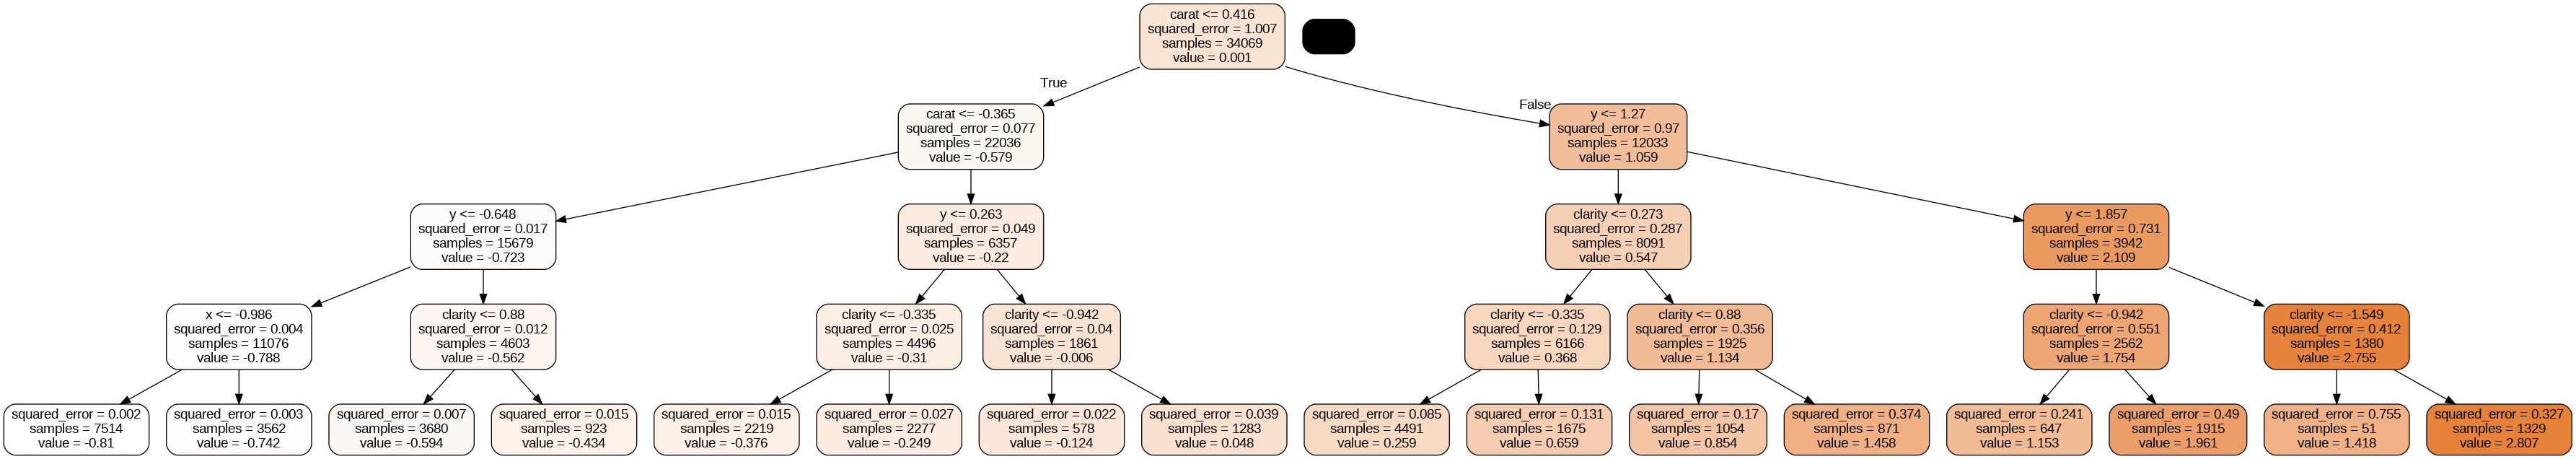

In [ ]:
for i, tree in enumerate(rf.estimators_):
    export_graphviz(tree, out_file=f'tree{i}.dot', feature_names=X_selected.columns, rounded=True, filled=True)

# # Convert each tree to a visual image using pydotplus
# for i in range(16):
#     graph = pydotplus.graph_from_dot_file(f'tree{i}.dot')
#     display(Image(graph.create_png()))

# just display one decision tree
graph =  pydotplus.graph_from_dot_file('tree0.dot')
display(Image(graph.create_png()))

The feature 'carat' is selected for branching at the root node. We can infer that this feature is one of the most important features for predicting the response variable ('price'). And this is because the root node of a decision tree is where making the first split, so the feature chosen for this split is the one that provides the most information gain.

Yes, the important feature corresponds to what we got in part 3.3.1.

### Q 7.4

In [ ]:
oob_score = rf.oob_score_
print("OOB score:", oob_score)

OOB score: 0.9194535025271935


From the source code of the _set_oob_score in RandomForestRegressor, we can find OOB score is calculated by taking the average R2 score across all outputs from decision trees. This means that the OOB score is a measure of how well the random forest model is able to predict the target values for new data, and the R2 score is a measure of how well the model fits the training data for each output. 

## Question 8.1

Here is the list of the important hyperparameters along with a search space for the tuning of these parameters for LightGBM:

    'learning_rate': Real(1e-4, 1e-1, 'log-uniform'),
    'num_leaves': Integer(10, 50),
    'max_depth': Integer(5, 50),
    'min_child_samples': Integer(1, 20),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'min_split_gain': Real(0.1, 1.0, 'uniform'),
    'reg_alpha': Real(0, 1.0, 'uniform'),
    'reg_lambda': Real(0, 1.0, 'uniform'),
    'n_estimators': Integer(50, 200)

## Question 8.2

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(prepared_diamonds_arr, price_arr, test_size=0.2, random_state=42)


In [ ]:
model_LGBM = lgb.LGBMRegressor()
search_space = {
    'learning_rate': Real(1e-4, 1e-1, 'log-uniform'),
    'num_leaves': Integer(10, 50),
    'max_depth': Integer(5, 50),
    'min_child_samples': Integer(1, 20),
    'subsample': Real(0.1, 1.0, 'uniform'),
    'min_split_gain': Real(0.1, 1.0, 'uniform'),
    'reg_alpha': Real(0, 1.0, 'uniform'),
    'reg_lambda': Real(0, 1.0, 'uniform'),
    'n_estimators': Integer(50, 200)
}
bayes_cv = BayesSearchCV(
    model_LGBM,
    search_spaces= search_space,
    scoring= 'neg_mean_squared_error',
    n_jobs=-1,
    cv=10
)

bayes_cv.fit(X_train, y_train)
best_params = bayes_cv.best_params_
best_rmse = np.sqrt(-bayes_cv.best_score_)
print(f"Best Hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse:.4f}")

Best Hyperparameters: OrderedDict([('learning_rate', 0.07310710381496958), ('max_depth', 50), ('min_child_samples', 1), ('min_split_gain', 0.1), ('n_estimators', 97), ('num_leaves', 50), ('reg_alpha', 0.0), ('reg_lambda', 0.6296161217547762), ('subsample', 1.0)])
Best RMSE: 0.1349


the best hyperparameter set found and the corresponding RMSE:
```
Best Hyperparameters: OrderedDict([
  ('learning_rate', 0.07174437108391152), 
  ('max_depth', 50), 
  ('min_child_samples', 1), 
  ('min_split_gain', 0.1), 
  ('n_estimators', 155), 
  ('num_leaves', 50), 
  ('reg_alpha', 1.0), 
  ('reg_lambda', 1.0), 
  ('subsample', 1.0)])
```
Best RMSE: 0.1348

## Question 8.3

The hyperparameters that help improve performance are: learning rate, n_estimators (number of trees), and max_depth (maximum depth of each tree). 
* learning_rate: a suitable learning rate can help improve the performance of a model by controlling the speed and stability of the optimization process (avoid vanishing/exploding gradient).
* n_estimators: a suitable n_estimators can help to make the model more robustness to noise (more decision trees makes the model more complex, and the error casued by an individual tree would be smoothed by the other trees).
* max_depth:  a suitable max_depth can make the model more complex (is able to capture more potential patterns) and perform better on generalized data.

The hyperparameters that help regularization are: learning_rate, max_depth, reg_alpha and reg_lambda. 
* learning_rate: a suitable learning rate slows down the optimization process and reduces the risk of overfitting by making smaller updates to the model parameters. Thus, it can help regularization.
* max_depth: a suitable max_depth can avoid the model fits the training data too well and performs badly on other unseen data. 
* reg_alpha and reg_lambda: reg_alpha and reg_lambda controls the regularization applied to the model. These hyperparameters prevent overfitting by adding a penalty to the loss function for large parameter values. 

The hyperparameters that affects the fitting efficiency are: learning_rate, min_split_gain.
* learning_rate: a suitable learning rate can reduce the number of iterations required to reach convergence, and thus improve the fitting efficiency. 
* min_split_gain: a suitable minimum split gain can reduce the complexity of the trees by reducing the number of splits and nodes required to capture the potential patterns in the data, and thus improve the fitting efficiency. 